In [1]:
import torch
import numpy as np
import os
import gc
import random
import cv2 as cv
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import dataloader

Auto-reload files imported to the notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [4]:
TILE_HEIGHT, TILE_WIDTH = 80, 80

For torch dataloader to use num_workers > 0, it relies on python multiprocessing, which in windows have deadlock issues, unless the instantiation is in a .py module and the code that invokes it is wrapped inside a \__main__ section.
https://github.com/pytorch/pytorch/issues/51344

In [5]:
if __name__ == '__main__':
    loader_train, loader_val, loader_test = dataloader.main(TILE_HEIGHT, TILE_WIDTH, batch_size=14, num_workers=2)

This method is used to plot single-channel tiles together.

In [28]:
def plot_tiles(img, num_tiles_v, num_tiles_h, channel=None):
    if channel != None:
        img = img[channel]
    v, h = num_tiles_v, num_tiles_h 
    fig, axs = plt.subplots(v, h) 
    for i in range(v):
        for j in range(h):
            # absolute is used because plt.imshow has odd habit of showing -0.0 as bright blocks
            axs[i,j].imshow(np.absolute(img[i*h+j]))
            axs[i,j].axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [7]:
# x, y = next(iter(loader_train))
# x, y = x[0], y[0]
# print('data size:', x.shape)
# v, h = int(480/TILE_HEIGHT), int(640/TILE_WIDTH)
# for c in range(3):
#     plot_tiles(x, v, h, c)
#     plot_tiles(y, v, h, c)
#     plot_tiles(x*y, v, h, c)

Here we import the resnet18 model with pretrained weights. This gives us some good starting weights so that we don't have to train the model from scratch. From there, we replace the last layer to work with the tiles format rather than resnet18's standard classification. Lastly, we freeze all of the layers except for the newly added layer so that it can be trained individually

In [8]:
resnet18 = models.resnet18(pretrained=True)
# replace last layer
resnet18.fc = nn.Linear(512, TILE_HEIGHT*TILE_WIDTH)
for param in resnet18.parameters():
    param.require_grad = False
resnet18.fc.requires_grad_(True)
# resnet18.modules

Linear(in_features=512, out_features=6400, bias=True)

This function is used to train the model

Reference: pytorch official tutorial (https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [9]:
def train(model, loader_train, loader_val, lr=1e-4, num_epochs=10, device='cpu', patience=5, evaluation_interval=200):
    # initialize lists to store logs of the validation loss and validation accuracy
    val_loss_hist = []
    val_acc_hist = []
    
    # initialize optimizer with specified learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # From documentation: This loss combines a Sigmoid layer and the BCELoss in one single class.
    loss_fn=nn.BCEWithLogitsLoss()
    
    # early-stopping parameters
    param_hist = []
    best_n_loss = None
    current_patience = patience
    # the number of training steps between evaluations
    stop_early = False
    
    for e in range(num_epochs):
        # set model to training mode
        model.train()
        # current batch index
        batch_num, num_batches = 0, len(loader_train)
        batch_acc_train = []
        batch_loss_train = []
        
        # Training pass
        for X_batch, y_batch in loader_train:
            # combine the batch and tile dimension
            X_batch = X_batch.reshape(-1, X_batch.shape[1], X_batch.shape[3], X_batch.shape[4])
            # add a dimension to match prediction shape
            # only take the first color channel of mask
            y_batch = y_batch[:,0,:,:,:].reshape(-1, y_batch.shape[-2] * y_batch.shape[-1])
            
            # torch tensor can be loaded to GPU, when applicable
            X_batch, y_batch = X_batch.float().to(device), y_batch.to(device)
            
            # reset gradients for the optimizer, need to be done each training step
            optimizer.zero_grad()
            
            # output here is logit (before passing through sigmoid)
            output = model(X_batch)
            # class=1 if logit > 0 is equivalent to class=1 if sigmoid(logit) > 0.5
            predictions = torch.where(output > 0, 1, 0)
            # loss_fn here is BCEWithLogitsLoss, which again includes the sigmoid layer
            batch_loss = loss_fn(output, y_batch.float())
            # compute the gradients and take optimization step
            batch_loss.backward()
            optimizer.step()

            batch_acc = torch.sum(predictions == y_batch)/(y_batch.shape[0]*y_batch.shape[1])
            
            batch_acc_train.append(batch_acc.item())
            batch_loss_train.append(batch_loss.item())
            
            # running average
            avg_train_acc = np.mean(batch_acc_train)
            avg_train_loss = np.mean(batch_loss_train)
            
            print('Training epoch %d batch %d/%d, train loss = %f, train acc = %f' 
                      %(e+1, batch_num+1, num_batches, avg_train_loss, avg_train_acc), end='\r')
            
            batch_num += 1
            
            if batch_num % 20 == 0:
                del X_batch
                del y_batch
                torch.cuda.empty_cache()
                gc.collect()
            
            # evaluate on validation set every 100 epochs, invoke early-stopping as needed (with patience)
            if batch_num % evaluation_interval == 0 or batch_num == num_batches:
                
                # evaluate the model
                print()
                total_loss_val, total_acc_val = evaluate_model(model, loader_val, loss_fn, device)
                
                print('validation metrics at epoch %d batch %d: val loss = %f, val acc = %f' 
                      %(e+1, batch_num, total_loss_val, total_acc_val))
                
                val_loss_hist.append(total_loss_val)
                val_acc_hist.append(total_acc_val)
                
                # early stopping with patience
                save_path = 'epoch_%d_batch_%d.model' %(e, batch_num)
                torch.save(model.state_dict(), save_path)
                param_hist.append(save_path)
                # only need to keep weights needed for earlystopping
                if len(param_hist) > patience+1:
                    del_path = param_hist.pop(0)
                    os.remove(del_path) # delete unnecessary state dicts
                if best_n_loss and total_loss_val >= best_n_loss:
                    current_patience -= 1
                    print('current_patience = %d' %current_patience)
                    if current_patience == 0: 
                        print('\nstopping early after no validation accuracy improvement in %d steps' 
                              % (patience * evaluation_interval))
                        best_weights_path = param_hist[-(patience+1)]
                        # restore to last best weights when stopping early
                        model.load_state_dict(torch.load(best_weights_path))
                        stop_early = True
                        break

                # if performance improves, reset patience and best accuracy
                else:
                    current_patience = patience
                    best_n_loss = total_loss_val
                        
        if stop_early:
            break
            
        # get epoch-wide training metrics
        epoch_loss_train = np.mean(batch_loss_train)
        epoch_acc_train = np.mean(batch_acc_train)
            
        print('='*80+'\nEpoch %d/%d train loss = %f, train acc = %f, val loss = %f, val acc = %f' 
              % (e+1, num_epochs, epoch_loss_train, epoch_acc_train, total_loss_val, total_acc_val))
        
    if device == 'cuda':
        torch.cuda.empty_cache() # free gpu memory if loaded to cuda
    else:
        gc.collect() # free memory if not using cuda
            
    # remove cached weights after stopping and loading best weights (if applicable) 
    cached_weight_paths = [f for f in os.listdir('.') if '.model' in f]
    for p in cached_weight_paths:
        os.remove(p)
    
    return (val_loss_hist, val_acc_hist)

In [20]:
def get_inference_output(model, X_in, device):
    model.eval()
    X_in = X_in.to(device)
    with torch.no_grad():
        output = model(X_in.float())
    return output

In [11]:
def evaluate_model(model, loader_val, loss_fn, device):
    acc_val = []
    loss_val = []
    err_x, err_y, err_pred = np.array([]), np.array([]), np.array([])
    val_batch_num, val_num_batches = 0, len(loader_val)
    # set model to eval mode when evaluating on validation set
    model.eval()
    for X_val, y_val in loader_val:
        # combine the batch and tile dimension
        X_val = X_val.reshape(-1, X_val.shape[1], X_val.shape[3], X_val.shape[4])
        # add a dimension to match prediction shape
        # only take the first color channel of mask
        y_val = y_val[:,0,:,:,:].reshape(-1, y_val.shape[-2] * y_val.shape[-1])
        X_val, y_val = X_val.to(device), y_val.to(device)
        with torch.no_grad():
            # output here is logit (before passing through sigmoid)
            output = get_inference_output(model, X_val, device)
            # class=1 if logit > 0 is equivalent to class=1 if sigmoid(logit) > 0.5
            predictions = torch.where(output > 0, 1, 0)
            batch_loss = loss_fn(output, y_val.float())
        batch_acc = torch.sum(predictions == y_val)/(y_val.shape[0]*y_val.shape[1])
        acc_val.append(batch_acc.item())
        loss_val.append(batch_loss.item())
        
        print('evaluating batch %d/%d'%(val_batch_num+1, val_num_batches), end='\r')
        val_batch_num += 1  
        
    del X_val
    del y_val
    torch.cuda.empty_cache()
    gc.collect()    

    # get validation metrics for this epoch
    total_acc_val = np.mean(acc_val)
    total_loss_val = np.mean(loss_val)
    
    # set model back to training mode after finishing evaluation
    model.train()
    
    return (total_loss_val, total_acc_val)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
resnet18 = resnet18.to(device)
train(resnet18, loader_train, loader_val, lr=1e-4, device=device, num_epochs=10, patience=5)

Device: cuda
Training epoch 1 batch 200/571, train loss = 0.130488, train acc = 0.964058
validation metrics at epoch 1 batch 200: val loss = 0.039080, val acc = 0.990616
Training epoch 1 batch 400/571, train loss = 0.084309, train acc = 0.977314
validation metrics at epoch 1 batch 400: val loss = 0.033178, val acc = 0.990616
Training epoch 1 batch 571/571, train loss = 0.069515, train acc = 0.981279
validation metrics at epoch 1 batch 571: val loss = 0.031966, val acc = 0.990616
Epoch 1/10 train loss = 0.069515, train acc = 0.981279, val loss = 0.031966, val acc = 0.990616
Training epoch 2 batch 200/571, train loss = 0.033517, train acc = 0.990529
validation metrics at epoch 2 batch 200: val loss = 0.030904, val acc = 0.990616
Training epoch 2 batch 400/571, train loss = 0.032892, train acc = 0.990560
validation metrics at epoch 2 batch 400: val loss = 0.029750, val acc = 0.990616
Training epoch 2 batch 571/571, train loss = 0.032393, train acc = 0.990574
validation metrics at epoch 2 

([0.039079781359350176,
  0.0331778721228032,
  0.031965694796871134,
  0.030904498239847977,
  0.02975036628859144,
  0.029129413153294106,
  0.02802012039637062,
  0.026260396019673685,
  0.025558852000345647,
  0.02465215690014228,
  0.02356809684613221,
  0.022842511534690857,
  0.02310033669878899,
  0.02244302556968071,
  0.021984590348643317,
  0.021974673520931055,
  0.021172527013949945,
  0.021646670708563964,
  0.02126737303612098,
  0.021156764523663992,
  0.020544989113236815,
  0.020420714701250404,
  0.02082005187764134,
  0.02085621350667846,
  0.02139060235988926,
  0.02002480938296083,
  0.019837667640875762,
  0.019826668209697997,
  0.020412401729066606,
  0.02018026397629103],
 [0.9906157775663994,
  0.9906157775663994,
  0.9906157775663994,
  0.9906157775663994,
  0.9906157775663994,
  0.9906157137642444,
  0.9906149086817889,
  0.9906289199708214,
  0.9906494357216526,
  0.9907128374341508,
  0.9909032003980287,
  0.990990655522951,
  0.9911785973629481,
  0.9911

In [13]:
for param in resnet18.parameters():
    param.require_grad = True
train(resnet18, loader_train, loader_val, lr=1e-4, device=device, num_epochs=10, patience=2)

Training epoch 1 batch 200/571, train loss = 0.020910, train acc = 0.991987
validation metrics at epoch 1 batch 200: val loss = 0.020609, val acc = 0.991913
Training epoch 1 batch 400/571, train loss = 0.020733, train acc = 0.992005
validation metrics at epoch 1 batch 400: val loss = 0.019583, val acc = 0.992236
Training epoch 1 batch 571/571, train loss = 0.020671, train acc = 0.992032
validation metrics at epoch 1 batch 571: val loss = 0.019517, val acc = 0.992275
Epoch 1/10 train loss = 0.020671, train acc = 0.992032, val loss = 0.019517, val acc = 0.992275
Training epoch 2 batch 200/571, train loss = 0.020252, train acc = 0.992088
validation metrics at epoch 2 batch 200: val loss = 0.019731, val acc = 0.992241
current_patience = 1
Training epoch 2 batch 400/571, train loss = 0.020282, train acc = 0.992156
validation metrics at epoch 2 batch 400: val loss = 0.019654, val acc = 0.992183
current_patience = 0

stopping early after no validation accuracy improvement in 400 steps


([0.02060905880701374,
  0.01958317767408952,
  0.01951724150493531,
  0.01973074329623454,
  0.019654371841272836],
 [0.9919134974479675,
  0.992236186081255,
  0.9922752472716319,
  0.992240653911107,
  0.9921834603161879])

In [51]:
x, y = next(iter(loader_test))

In [52]:
x.shape, y.shape

(torch.Size([14, 3, 48, 80, 80]), torch.Size([14, 3, 48, 80, 80]))

In [53]:
x_out = get_inference_output(resnet18, x.reshape(-1, x.shape[1], x.shape[3], x.shape[4]), device)
x_out = torch.where(x_out > 0, 1, 0)

In [54]:
x_out_reshaped = x_out.reshape(-1, y.shape[2], y.shape[3], y.shape[4]).cpu()
x_out_reshaped.shape

torch.Size([14, 48, 80, 80])

C:\Users\gorde\AppData\Local\Temp/ipykernel_61744/2167702001.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(v, h)


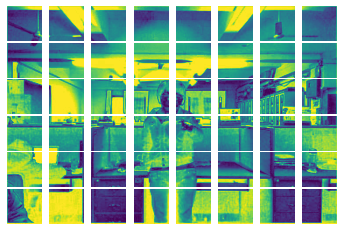

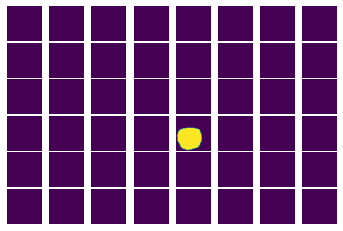

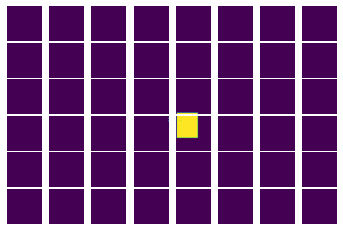

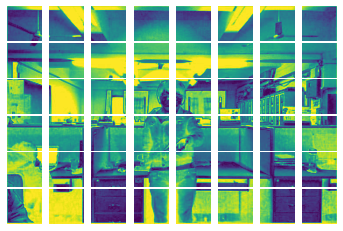

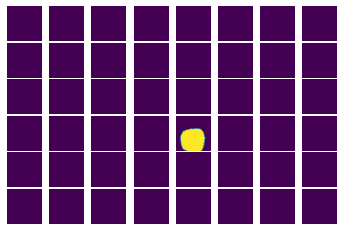

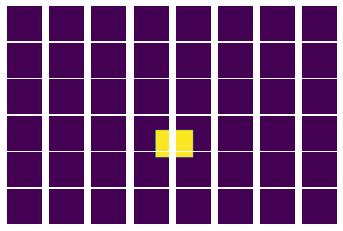

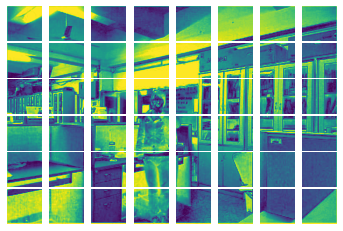

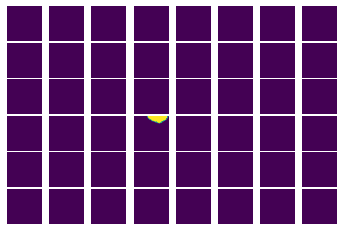

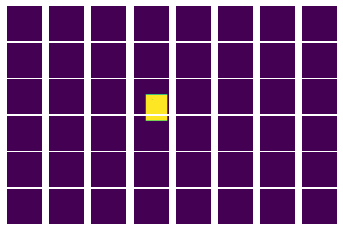

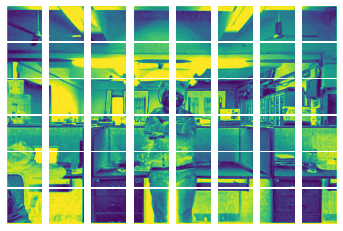

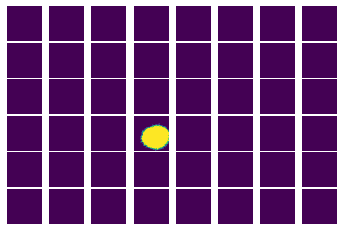

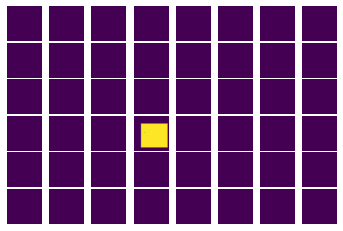

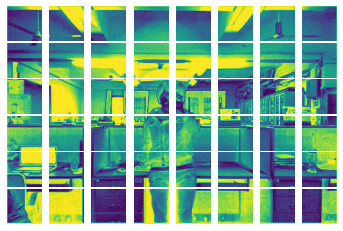

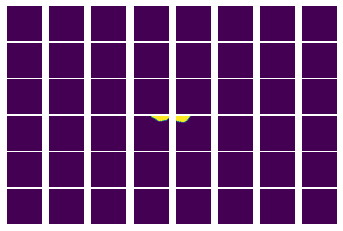

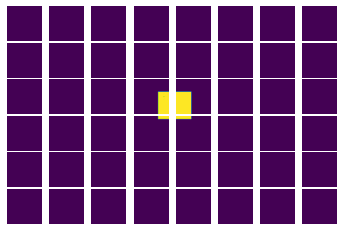

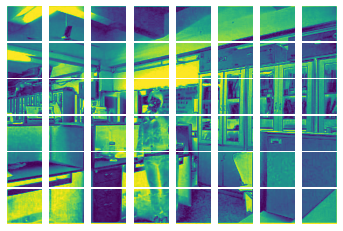

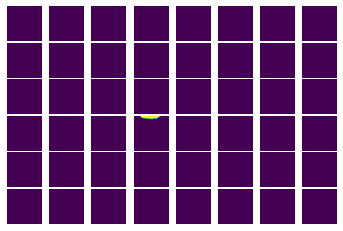

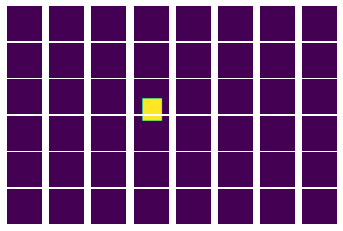

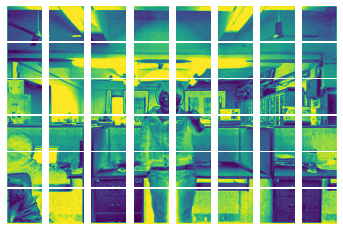

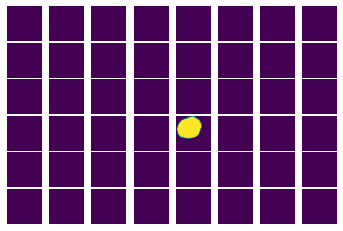

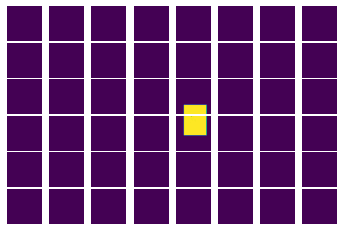

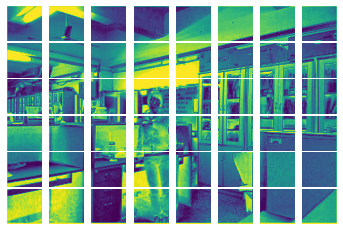

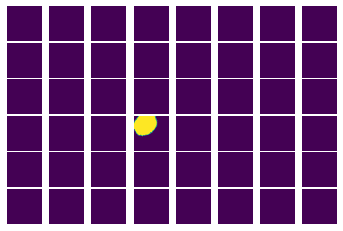

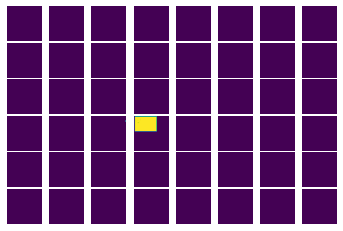

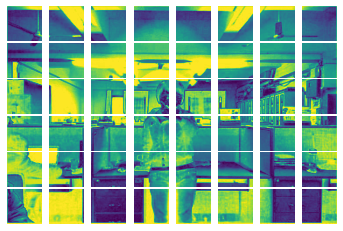

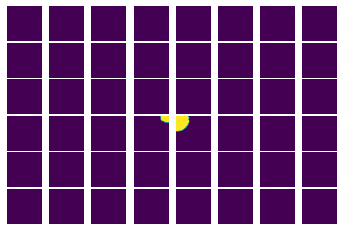

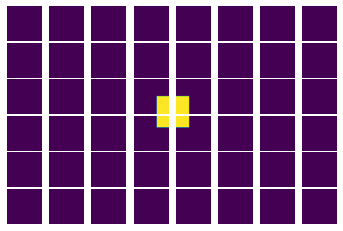

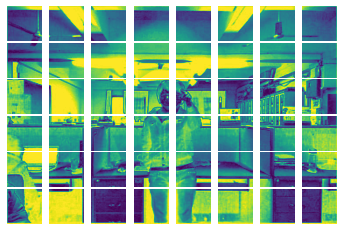

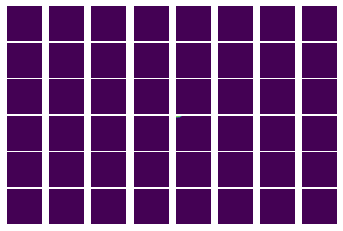

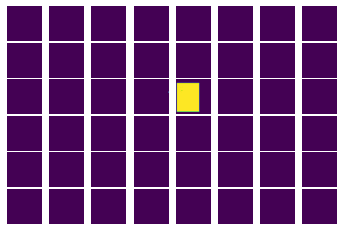

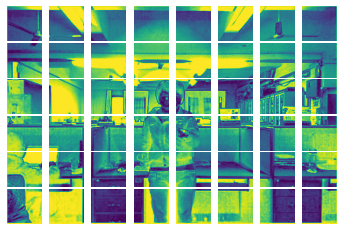

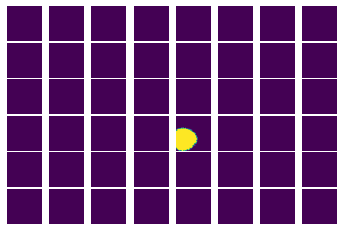

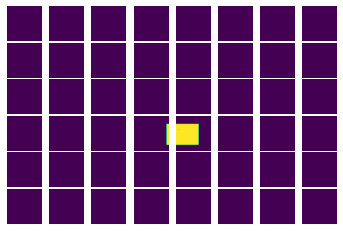

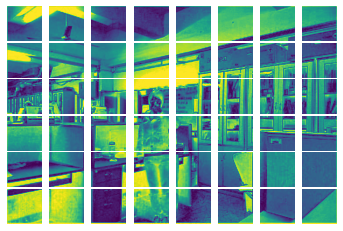

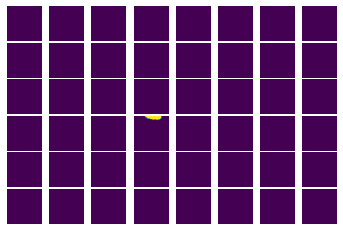

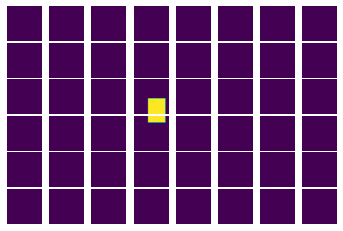

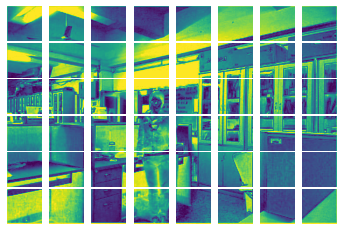

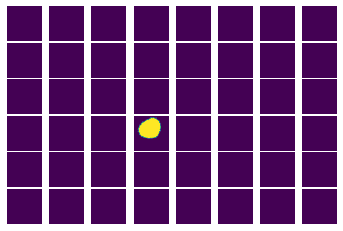

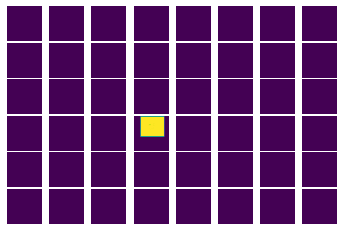

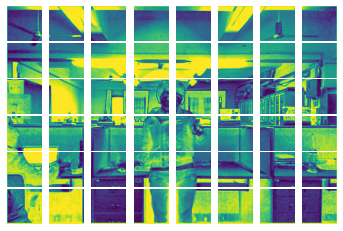

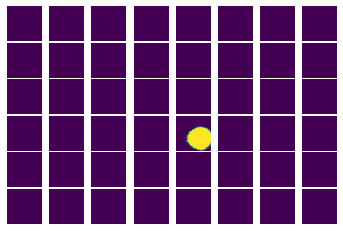

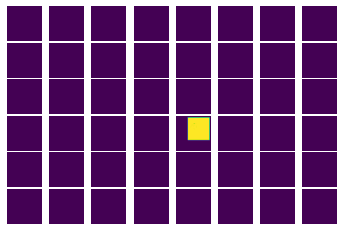

In [57]:
v, h = int(480/TILE_HEIGHT), int(640/TILE_WIDTH)
for i in range(x.shape[0]):
    plot_tiles(x[i], v, h, 0)
    plot_tiles(x_out_reshaped[i], v, h)
    plot_tiles(y[i], v, h, 0)